# Collaborative Filtering - Item CF Example
<img src="http://grouplens.org/site-content/uploads/ml-logo.png"/>


We are going to use the Movielens dataset to build a recommendation system. The dataset provides recommendations over 100,000 ratings from 1000 users on 1700 movies. Full data can be found [here](http://grouplens.org/datasets/movielens/100k/). Please go ahead and download/unzip the data before we continue.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline


In [2]:
# You will have to possibly change where "u.data" and "u.item" can be found after downloading the dataset!

rating_headers = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_ratings = pd.read_csv('u.data',sep="\t",names=rating_headers)

movie_headers = ['movie_id','title','release_date','video_release_date','imdb_url','unknown','action','adventure',
                 'animation','childrens','comedy','crime','docu','drama','fantasy','film-noir','horror','musical',
                 'mystery','romance','scifi','thriller','war','western']
movie_titles = pd.read_csv('u.item',sep='|',names=movie_headers)

In [3]:
movie_ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# We don't really care for the timestamp, so lets drop it
movie_ratings.drop("timestamp",axis=1,inplace=True)
movie_ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [5]:
movie_titles.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,childrens,...,fantasy,film-noir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# For now, all we really care about are the movie_id and the title-- the first two columns
movie_titles.drop(movie_titles.columns[2:movie_titles.shape[1]],axis=1,inplace=True)
movie_titles.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
# Okay, let's merge on the movie ratings and movie titles by movie id
# This will give us a more easily readable dataset
df = movie_ratings.merge(movie_titles)
df.head()

,user_id,movie_id,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


In [8]:
# What do these ratings look like?
df.rating.value_counts()

4    34174
3    27145
5    21201
2    11370
1     6110
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a4b18d0>]], dtype=object)

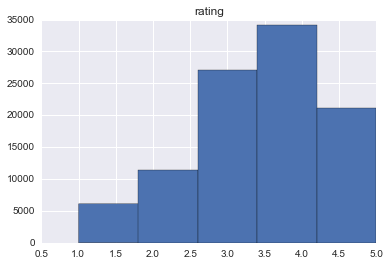

In [9]:
df.hist('rating',bins=5) 

# Gameplan


Okay, so we have a full dataset. We want to now perform some item based collaborative filtering. Before we can do that, we should normalize the ratings globally, and then reform the data into a matrix of user x movie.

**Quiz:** Why would we not want to normalize ratings per movie?



In [10]:
df['rating_norm'] = df.rating - df.rating.mean()
df.head()

,user_id,movie_id,rating,title,rating_norm
0,196,242,3,Kolya (1996),-0.52986
1,63,242,3,Kolya (1996),-0.52986
2,226,242,5,Kolya (1996),1.47014
3,154,242,3,Kolya (1996),-0.52986
4,306,242,5,Kolya (1996),1.47014


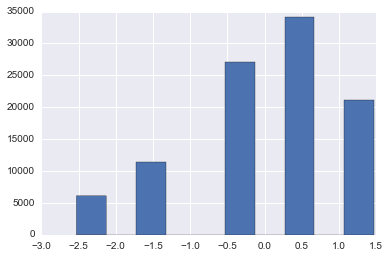

In [11]:
df.rating_norm.hist()

In [12]:
# Going to use pivot_table to create exactly the matrix we want of user x movie, where each entry is
# the rating. We will 0 fill if there is no rating.
user_item_df = df.pivot_table(values="rating_norm",index="user_id",columns="title",fill_value=0)
user_item_df.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,� k�ldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,-1.52986,1.47014,0.00000,0,-0.52986,0.47014,0.00000,0,...,0,0,0,1.47014,-0.52986,0,0,0,0.47014,0
2,0,0,0.00000,0.00000,0.00000,0,0.00000,0.00000,-2.52986,0,...,0,0,0,0.00000,0.00000,0,0,0,0.00000,0
3,0,0,0.00000,0.00000,-1.52986,0,0.00000,0.00000,0.00000,0,...,0,0,0,0.00000,0.00000,0,0,0,0.00000,0
4,0,0,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,0,...,0,0,0,0.00000,0.00000,0,0,0,0.00000,0
5,0,0,-1.52986,0.00000,0.00000,0,0.00000,0.47014,0.00000,0,...,0,0,0,0.47014,0.00000,0,0,0,0.47014,0


There are many similarity metrics we could use to create a similarity matrix. The similarity matrix is a square matrix of item x item, where each entry is a metric with how similar the two items are.

In this instance, we're going to define the similarity by column wise correlations.

In [13]:
corr_mat = pd.DataFrame(np.corrcoef(user_item_df,rowvar=0,bias=1),
                        index=user_item_df.columns,
                        columns=user_item_df.columns)

In [14]:
corr_mat.loc[:,"Toy Story (1995)"].order(ascending=False)[:10] 

title
Toy Story (1995)                             1.000000
Beauty and the Beast (1991)                  0.281575
Aladdin (1992)                               0.270408
Apollo 13 (1995)                             0.259016
Lion King, The (1994)                        0.246914
Raiders of the Lost Ark (1981)               0.236894
Jurassic Park (1993)                         0.221541
E.T. the Extra-Terrestrial (1982)            0.216962
Indiana Jones and the Last Crusade (1989)    0.214377
Back to the Future (1985)                    0.197925
Name: Toy Story (1995), dtype: float64

Pretty good! "Youve watched Toy Story. You might also like Beauty and the Beast and Aladdin. (And maybe Apollo 13)"

# Exercise 1:
    


**Part 1** 

If you create a similarity matrix using vector cosine similarity rather than correlation, how do the top 10 "similar" movies for "Toy Story (1995)" change? Do they make sense?

<img src="https://upload.wikimedia.org/math/7/0/6/706e3fbc6408ba68798bc970fc8a1fc6.png"/>

Given two movies `a` and `b`, you could compute this quantity as:
```
a.dot(b)/( np.linalg.norm(a) * np.linalg.norm(b) )
```
Hint: Think about how you could make this into a matrix operation

In [59]:
xx = user_item_df.apply(lambda x: x / np.linalg.norm(x),axis=0)

vec_mat = xx.T.dot(xx)

vec_mat.loc[:,"Toy Story (1995)"].order(ascending=False)[:10]

title
Toy Story (1995)                             1.000000
Raiders of the Lost Ark (1981)               0.310892
Apollo 13 (1995)                             0.302507
Beauty and the Beast (1991)                  0.300320
Aladdin (1992)                               0.294422
Star Wars (1977)                             0.292913
Lion King, The (1994)                        0.267139
Indiana Jones and the Last Crusade (1989)    0.261589
Empire Strikes Back, The (1980)              0.260567
Schindler's List (1993)                      0.255726
Name: Toy Story (1995), dtype: float64

In [18]:
vec_mat = pd.DataFrame(0,
                        index=user_item_df.columns,
                        columns=user_item_df.columns)

vec_mat

for movie_a in user_item_df.columns:
    for movie_b in user_item_df.columns:
        vec_mat.loc[movie_a,movie_b] = user_item_df.loc[:,movie_a].dot( user_item_df.loc[:,movie_b]) / np.linalg.norm(user_item_df.loc[:,movie_a]) / np.linalg.norm(user_item_df.loc[:,movie_b])

KeyboardInterrupt: 

Look at movie number 10. You would definitely want a hybrid approach here!!!

**Part 2**

We are going to go back to using the correlation matrix now. Let's do some predictions for user 224. (i.e. You will want to use the Pandas "loc" function to access the _label_ 224, and not the _index_ 224. [More here](http://pandas.pydata.org/pandas-docs/stable/indexing.html)


What are the top 10 movies that user 224 liked?

In [19]:
user_item_df.loc[224,:].order(ascending=False)[:10]

title
Titanic (1997)               1.47014
Hamlet (1996)                1.47014
Dances with Wolves (1990)    1.47014
Somewhere in Time (1980)     1.47014
Braveheart (1995)            1.47014
Schindler's List (1993)      1.47014
Ghost (1990)                 1.47014
Forrest Gump (1994)          0.47014
Little Women (1994)          0.47014
Tombstone (1993)             0.47014
Name: 224, dtype: float64

**Part 3**

Now, we are going to recommend user 224 some movies! The simplest way to get a set of recommended movies is to take the dot product of user_224 with our correlation matrix.
```
user_224_recs = user_224_series.dot( corr_mat )
```

What are the top 10 movies we would recommend user 224?

In [20]:
myUser = user_item_df.loc[224,:] 
myUserRecs = pd.Series(myUser.T.dot(corr_mat),index=corr_mat.index) 
myUserRecs.order(ascending=False)[:10]

title
Braveheart (1995)                 4.722225
Hamlet (1996)                     4.646045
Schindler's List (1993)           4.432198
Spanish Prisoner, The (1997)      3.735947
Brothers in Trouble (1995)        3.735947
Butcher Boy, The (1998)           3.735947
Glory (1989)                      3.705769
Titanic (1997)                    3.657347
Friday (1995)                     3.172157
Man Without a Face, The (1993)    3.024315
Name: 224, dtype: float64

**Part 4**

This is hard to visualize if our item based collaborative filtering is working well or not. Let's use seaborn to plot out a scatter of the items they rated, and our predictions for those items.
```
sb.regplot( user_224_series, user_224_recs )
```

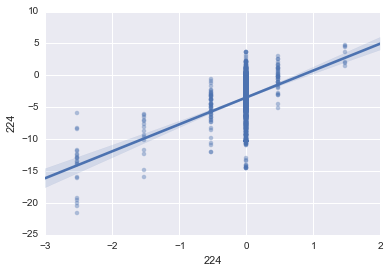

In [21]:
sb.regplot(myUser,myUserRecs,scatter_kws=dict(alpha=.4))

Pretty good. We can ignore the actual numbers, but look at the trend. Roughly speaking, our predictions correlate well with their actually posted reviews. Now to be more accurate, we would have to run cross validation tests to confirm our recommendation engine.


# Exercise 2:

Recall the previous lecture's example on SVD. This time, use TruncatedSVD from the sklearn.decomposition module in order to decompose our data matrix of user x movie (where each item is the normalized rating).

* Use TruncatedSVD to fit_transform our data matrix into a reduced matrix.
* Plot the cumulative sum of explained\_variance\_ratio\_.
* Plot horizontal bargraphs of the first 8 components. What are the weights of the top 10 movies for each of these components?
* Reconstruct the matrix using the svd.inverse_transform function and pass in your reduced matrix. This is equivalent to the following operation: reduced\_matrix.dot( svd.components\_ ). What are the top 10 recommendations for user 224?
* Plot using sb.regplot user 224's ratings as well as the new recommendations for user 224.

# Exercise 3 (Optional):


The SVD method does not work as well when the matrix is very sparse (like now). Most recommendation systems instead try to model users and movies along some hidden feature space. The problem is having to solve for both some matrix X (user to feature) and some matrix Y (feature to movie). This can be solved using alternating least squares.

Rough procedure, for N iterations:
* Fix X. Solve for Y.
* Fix Y. Solve for X.

The following blog post has an example of alternative least squares solution. Try writing a version to solve and recommend based on the post:

http://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/


In [15]:
from sklearn import decomposition

In [16]:
svd = decomposition.TruncatedSVD(n_components=500)

In [17]:
user_item_df_red = svd.fit_transform(user_item_df)

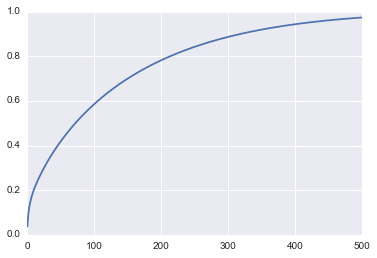

In [18]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))

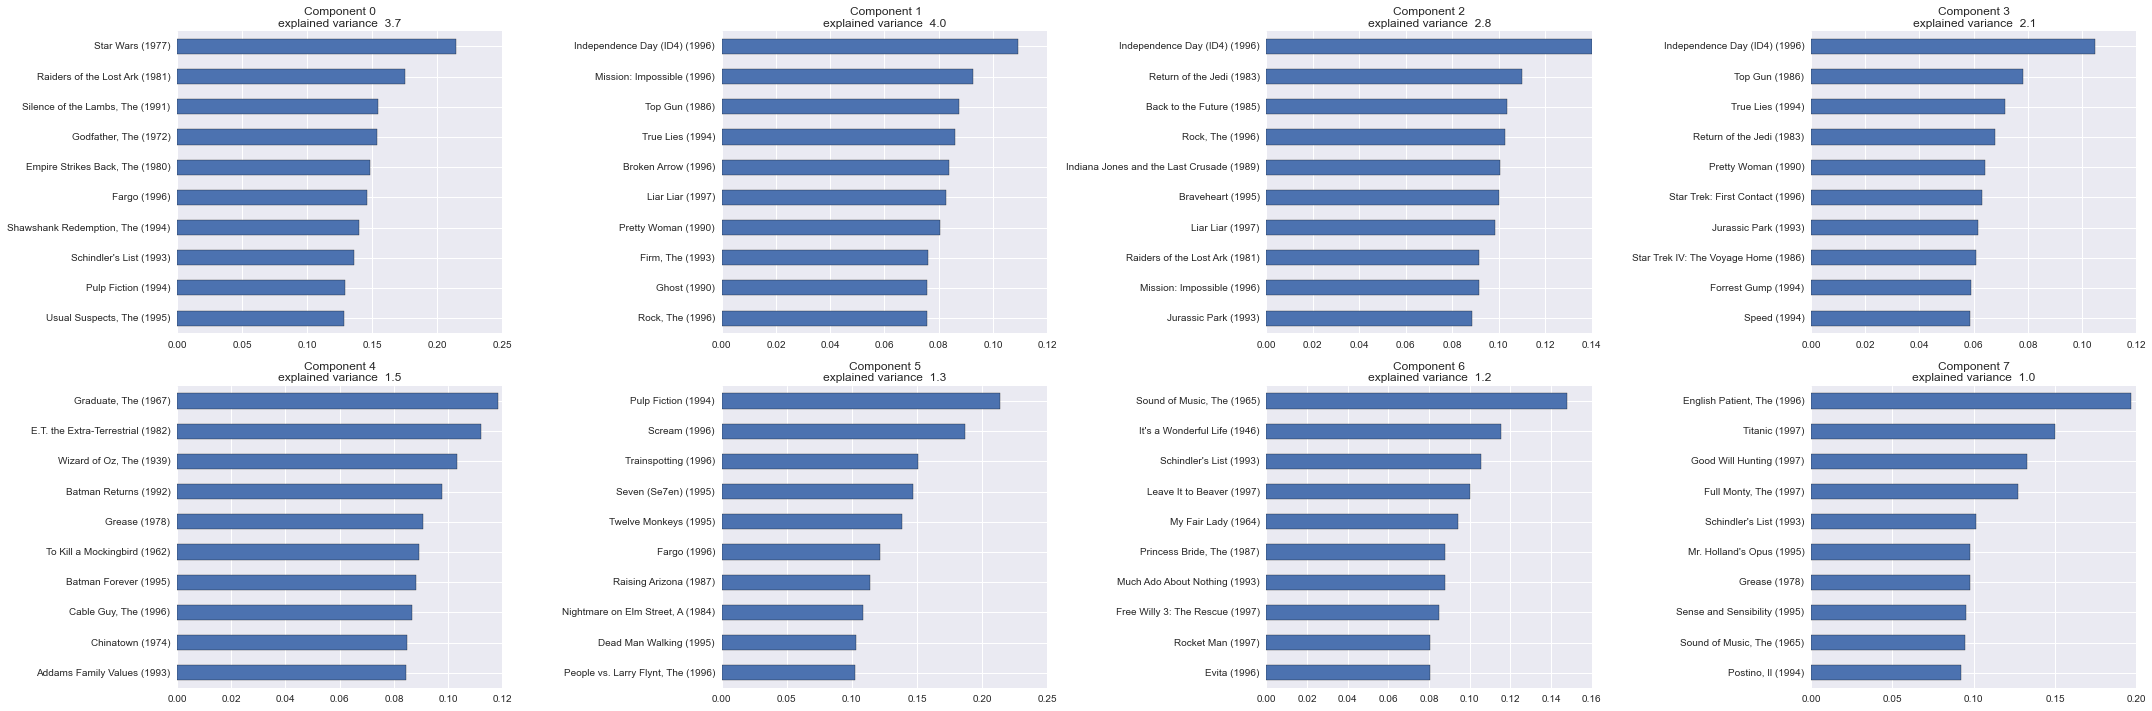

In [19]:
top_components=8

plt.figure(figsize=(30,10))

#f, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))

for no, component in enumerate(svd.components_[:top_components]):
    plt.subplot(2,4,no+1)
    s = pd.Series(svd.components_[no], index=user_item_df.columns.values).sort(inplace=False)[-10:]
    s.plot(kind='barh', title="Component %d\nexplained variance %4.1f" % (no, 100 * svd.explained_variance_ratio_[no]))

f = plt.tight_layout()

In [26]:
user_item_df_rec = pd.DataFrame( svd.inverse_transform( user_item_df_red ), 
                                index= user_item_df.index, 
                                columns= user_item_df.columns )

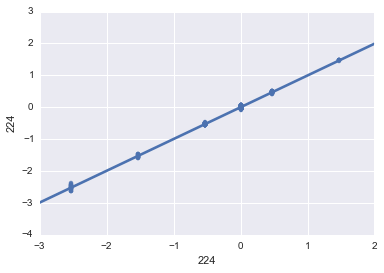

In [38]:
sb.regplot(user_item_df.loc[224,:],user_item_df_rec.loc[224,:])

In [42]:
print user_item_df.loc[224,:].order(ascending=False)[:10]

print user_item_df_rec.loc[224,:].order(ascending=False)[:10]

title
Titanic (1997)               1.47014
Hamlet (1996)                1.47014
Dances with Wolves (1990)    1.47014
Somewhere in Time (1980)     1.47014
Braveheart (1995)            1.47014
Schindler's List (1993)      1.47014
Ghost (1990)                 1.47014
Forrest Gump (1994)          0.47014
Little Women (1994)          0.47014
Tombstone (1993)             0.47014
Name: 224, dtype: float64
title
Somewhere in Time (1980)         1.495525
Ghost (1990)                     1.479694
Dances with Wolves (1990)        1.475305
Hamlet (1996)                    1.474767
Titanic (1997)                   1.471440
Braveheart (1995)                1.468243
Schindler's List (1993)          1.459073
Star Trek: Generations (1994)    0.512050
Up Close and Personal (1996)     0.504793
Piano, The (1993)                0.500854
Name: 224, dtype: float64
